In [1]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import date
import numpy as np
import copy
import yahoo_fin.stock_info as si
import seaborn as sns


# from https://medium.com/@maneesh1.kumar/correlating-vix-and-spy-a-statistical-study-using-pythons-linear-regression-9261bfd9dd71

def load_SPY_VIX(start_date = date(2000,1,1),
                end_date = date(2023,1,1)
                ):
    dfSPY = si.get_data('SPY',start_date=start_date, end_date=end_date).round(1)[['adjclose']]
    dfVIX = si.get_data('^VIX',start_date=start_date, end_date=end_date).round(1)[['adjclose']]
    dfSPY.columns=['SPY']
    dfVIX.columns=['VIX']
    df=dfSPY.join(dfVIX).dropna()
    return df

def sim_VS(params, dt, N, S_init=100, V_init=-0.5, dw=None):
    # assuming constant mu
    mu, lambda_v, theta, sigma_v, ro = params
    ro_hat = np.sqrt(1-ro**2)
    
    # independently sampled dw are stacked together
    if dw is None:
        dw = [np.sqrt(dt) * np.random.normal(size=N)
              for i in range(2)]
    
    V = np.zeros(N)
    S = np.zeros(N)
    V[0] = V_init
    S[0] = S_init
    
    for i in range(1, N):
        V[i] = V[i-1] + lambda_v*(theta - V[i-1])*dt + sigma_v*ro*dw[0][i-1] + sigma_v*ro_hat*dw[1][i-1]
        S[i] = S[i-1] + S[i-1]*(np.exp(V[i-1])*mu*dt + np.exp(V[i-1])*dw[0][i-1])
    
    return S, V, dw

def sim_VSmu(params, dt, N, S_init=100, V_init=-0.5, mu_init=10, dw=None):
    rho, sigma_v, sigma_mu, lambda_v, lambda_mu, theta, theta_mu = params
    rho_hat = np.sqrt(1-rho**2)
    
    # independently sampled dw are stacked together
    if dw is None:
        dw = [np.sqrt(dt) * np.random.normal(size=N)
              for i in range(3)]
    
    S, V, mu = np.zeros((3, N))
    V[0] = V_init
    S[0] = S_init
    mu[0] = mu_init
    
    for i in range(1, N):
        mu[i] = mu[i-1] + lambda_mu*(theta_mu - mu[i-1])*dt + sigma_mu*dw[2][i-1]
        V[i] = V[i-1] + lambda_v*(theta - V[i-1])*dt + sigma_v*rho*dw[0][i-1] + sigma_v*rho_hat*dw[1][i-1]
        S[i] = S[i-1] + S[i-1]*(np.exp(V[i-1])*mu[i-1]*dt + np.exp(V[i-1])*dw[0][i-1])
    
    return S, V, mu, dw


it: 0  [-0.75  0.3   0.4   4.    0.5  -1.    0.2 ]
it: 0  [-0.79  0.3   0.4   4.    0.5  -1.    0.2 ]
it: 0  [-0.75  0.32  0.4   4.    0.5  -1.    0.2 ]
it: 0  [-0.75  0.3   0.42  4.    0.5  -1.    0.2 ]
it: 0  [-0.75  0.3   0.4   4.2   0.5  -1.    0.2 ]
it: 0  [-0.75  0.3   0.4   4.    0.53 -1.    0.2 ]
it: 0  [-0.75  0.3   0.4   4.    0.5  -1.05  0.2 ]
it: 0  [-0.75  0.3   0.4   4.    0.5  -1.    0.21]
it: 0  [-0.71  0.3   0.41  4.06  0.51 -1.01  0.2 ]
it: 0  [-0.67  0.31  0.41  4.09  0.51 -1.02  0.2 ]
it: 0  [-0.73  0.31  0.41  3.82  0.51 -1.02  0.2 ]
it: 0  [-0.72  0.31  0.41  3.97  0.48 -1.03  0.21]
it: 0  [-0.71  0.31  0.41  3.97  0.5  -1.03  0.19]
it: 0  [-0.7   0.31  0.42  3.96  0.5  -1.04  0.2 ]
it: 0  [-0.68  0.32  0.43  3.94  0.5  -1.07  0.2 ]
it: 0  [-0.68  0.32  0.4   3.94  0.5  -1.06  0.2 ]
it: 0  [-0.67  0.32  0.42  3.92  0.5  -1.02  0.2 ]
it: 0  [-0.62  0.34  0.43  3.88  0.5  -1.    0.21]
it: 0  [-0.63  0.31  0.43  3.89  0.5  -1.06  0.21]
it: 0  [-0.62  0.33  0.42  4.08

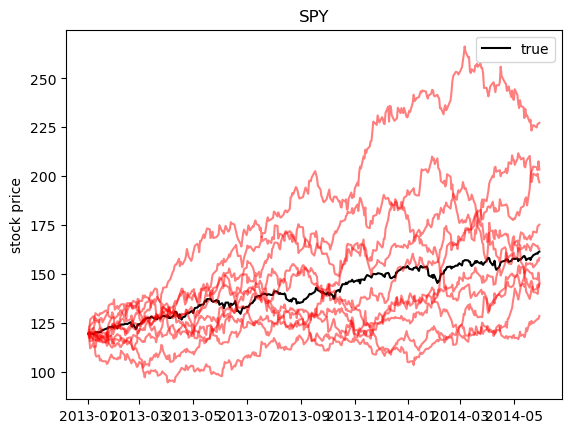

In [2]:
np.set_printoptions(precision=2)
offset = 1e-10 # avoid divide by zero

#implement the log-likelihood calculations

#
def create_C(V, rho, sigma_v, dt, i):
    #2X2 MATRIX, added offset to avoid devide by zero
    C_i = (1 / ((1-rho**2) * (np.exp(2*V[i-1])*sigma_v**2) * dt + offset) * \
           np.array([[sigma_v**2, -rho * np.exp(V[i - 1]) * sigma_v],
                     [-rho * np.exp(V[i - 1]) * sigma_v, np.exp(2 * V[i - 1])]]))
    return C_i

def create_m(V, dt, i):
    #2X2 MATRIX
    M_i = np.array([[-np.exp(V[i - 1]) * dt, 0], [0, 0]])
    return M_i

def create_r(V, S, lambda_v, theta, dt, i):
    #COLUMN VECTOR
    Ret = np.diff(np.log(S))
    Ret_V = np.diff(V)
    r_i = (np.array([[Ret[i]], [Ret_V[i]]])
           - np.array([[-0.5 * np.exp(2 * V[i - 1]) * dt], 
                       [lambda_v * (theta - V[i - 1]) * dt]]))
    return r_i

def create_P(sigma_mu, lambda_mu, theta_mu, dt):
    #ROW VECTOR, added offset to avoid devide by zero
    P = 1 / (sigma_mu * np.sqrt(dt) + offset) \
        * np.array([[-1 + dt*lambda_mu, 1]])
    return P

def create_s(sigma_mu, lambda_mu, theta_mu, dt):
    #CONSTANT, added offset to avoid devide by zero
    s = -dt * lambda_mu * theta_mu / (sigma_mu * np.sqrt(dt) + offset)
    return s
    
def define_matrix_E_i(i, n):
    # E is a selection matrix, I think
    E = np.zeros((2, n))
    E[0, i - 1] = 1
    E[1, i] = 1
    return E

def define_matrix_E_n_minus_1(n):
    E = np.zeros((2, n))
    E[0, n - 1] = 1
    return E
def implement_equations(V, S, params, dt):
    
    rho, sigma_v, sigma_mu, lambda_v, lambda_mu, theta, theta_mu = params
    n = len(V)-1
    #P, s are constant
    P = create_P(sigma_mu, lambda_mu, theta_mu, dt)
    s = create_s(sigma_mu, lambda_mu, theta_mu, dt)
        
    #
    for i in range(1, n):
        E_i = define_matrix_E_i(i, n)
        M_i = create_m(V, dt, i)
        C_i = create_C(V, rho, sigma_v, dt, i)
        r_i = create_r(V, S, lambda_v, theta, dt, i)
        if i == 1:
            A = E_i.T @ (M_i.T @ C_i @ M_i + P.T @ P) @ E_i
            B = (r_i.T @ C_i @ M_i + s*P) @ E_i
            rcr = r_i.T @ C_i @ r_i
        else:
            A += E_i.T @ (M_i.T @ C_i @ M_i + P.T @ P) @ E_i
            B += (r_i.T @ C_i @ M_i + s*P) @ E_i
            rcr += r_i.T @ C_i @ r_i
    
    E_n_minus_1 = define_matrix_E_n_minus_1(n)
    M_n_minus_1 = create_m(V, dt, n-1)
    C_n_minus_1 = create_C(V, rho, sigma_v, dt, n-1)
    r_n_minus_1 = create_r(V, S, lambda_v, theta, dt, n-1)
    
    A += E_n_minus_1.T @ M_n_minus_1.T @ C_n_minus_1 @ M_n_minus_1 @ E_n_minus_1
    B += r_n_minus_1.T @ C_n_minus_1 @ M_n_minus_1 @ E_n_minus_1

    # rcr += r_n_minus_1.T @ C_n_minus_1 @ r_n_minus_1
    
    sign, logdet = np.linalg.slogdet(A)
    # if logdet == -np.inf: # if A is singular
    #     A[0, 0] += offset
    #     logdet = offset**-1
    #     sign = -1
    # added offset to avoid devide by zero
    ll = -(n-1)*np.log(sigma_mu*dt**0.5 + offset) \
        - n*np.log(2*np.pi*sigma_v*dt*(1-rho**2)**0.5 + offset) - np.sum(V[:-1]) \
        - (rcr + n*s**2) / 2 \
        + np.log(2*np.pi)*n/2 - 0.5*sign*logdet + 0.5*B@np.linalg.inv(A)@B.T #np.linalg.solve(A, B.T) #
    ll = ll.item()
    
    return ll

neg_log_likelihood_values = []
def neg_log_likelihood(params, V, S, dt, it=None):
    ll = implement_equations(V, S, params, dt)
    neg_log_likelihood_values.append(-ll)
    # for dubugging
    print(f'it: {it} ', params)
    # print(-ll)
    
    return -ll  #Negative because we are minimizing
# Initial guesses for your parameters
initial_params = [-0.75, 0.3, 0.4, 4., .5, -1, .2] 

bounds = [(-1, -0.2), (0, None), (0, None), (0, None), (0, None), (None, None), (None, None)]

# start and end dates for importing real SPY & VIX data
# start_date = date(2023,1,1)
start_date = date(2013,1,1)
end_date = date(2014,6,1)
# end_date = date.today()

data = load_SPY_VIX(start_date=start_date, end_date=end_date)
spy, vix = data['SPY'].to_numpy(), data['VIX'].to_numpy() 
vol = np.log(vix/100)

dt = 0.01
N = len(spy)

results = []
for i in range(1):# number of iteration
    # Choose an optimizer that supports bounds, e.g., L-BFGS-B
    params0 = np.array(initial_params) #* (0.75+0.5*np.random.randn(len(initial_params))) # init param to initialise minimizer
    result = minimize(neg_log_likelihood, params0, 
                      method='Nelder-Mead', # method='L-BFGS-B', 
                      args=(vol, spy, dt, i),
                      bounds=bounds,
                      options={'maxiter': 500},
                      tol=0.01,
                      )
    results.append(result.x)
    
avg_param = np.mean(results, axis=0)

SVmu_lst = [sim_VSmu(avg_param, dt, N,
                     S_init=spy[0], V_init=vol[0], mu_init=avg_param[-1]
                     )[:3]
            for i in range(10)
            ] # [samples, SPY/Vol, value]


plt.figure()
plt.plot(data.index, spy, label='true', c='k')
for S, V, mu in SVmu_lst:
    plt.plot(data.index, S, c='r', alpha=0.5)
plt.title('SPY')
plt.ylabel('stock price')
plt.legend()
plt.show()

plt.plot(neg_log_likelihood_values)


In [66]:
start_date = date(2010,1,1)
end_date = date(2020,6,1)
# end_date = date.today()

data = load_SPY_VIX(start_date=start_date, end_date=end_date)
spy, vix = data['SPY'].to_numpy(), data['VIX'].to_numpy() 
vol = np.log(vix)


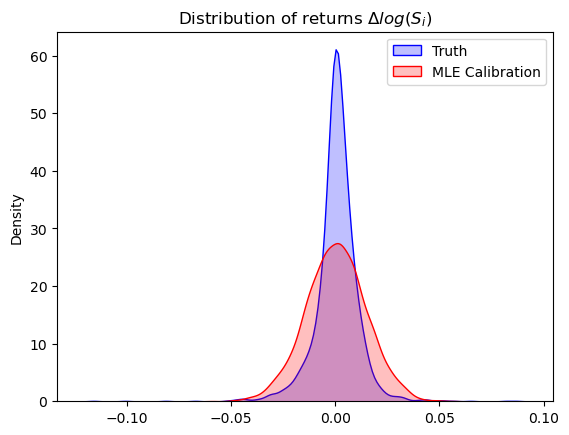

In [67]:
#compare truth with our calibration in distribution

all_log_diffs = []

for S, _, _ in SVmu_lst:
    log_diff = np.diff(np.log(S))
    all_log_diffs.extend(log_diff)


sns.kdeplot(np.diff(np.log(spy)),fill=True,color='blue',label='Truth')
sns.kdeplot(all_log_diffs,fill=True,color='red',label='MLE Calibration')

plt.title('Distribution of returns $\Delta log(S_i)$')
plt.legend()
plt.savefig('spy_dist.png',dpi=120)
plt.show()

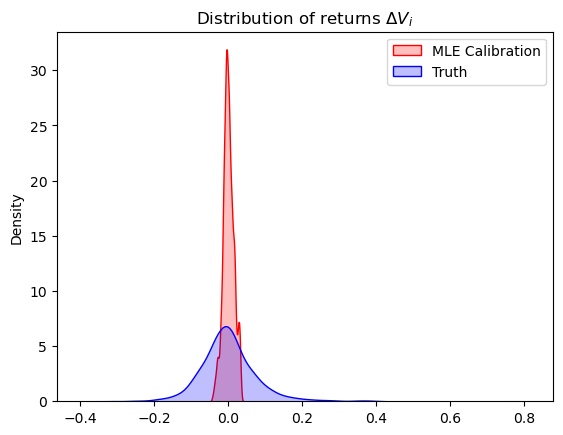

In [68]:
all_diffs = []

for S, V, _ in SVmu_lst:
    diff = np.diff(V)
    all_diffs.extend(log_diff)


sns.kdeplot(all_diffs,fill=True,color='red',label='MLE Calibration')
sns.kdeplot(np.diff(vol),fill=True,color='blue',label='Truth')


plt.title('Distribution of returns $\Delta V_i$')
plt.legend()
plt.savefig('v_dist.png',dpi=120)
plt.show()